# Experiment of adversarial-camera-stickers

Consider digital attacks only.

## Data preparation and preprocessings

In [1]:
from skimage import io
img_array = io.imread("../image/1200px-STOP_sign.jpg")

In [2]:
img_array.shape

(1296, 1200, 3)

In [3]:
import matplotlib.pyplot as plt

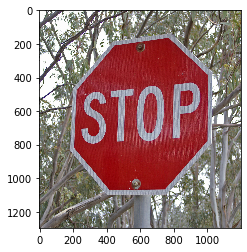

In [4]:
plt.figure()
plt.imshow(img_array)
plt.show()

In [5]:
from torchvision import transforms
import PIL
import copy


composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


def plot_img_from_normalized_img(img_array, is_normalized=True):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

In [6]:
transformed_img = composed(PIL.Image.fromarray(img_array))

In [7]:
transformed_img.shape

torch.Size([3, 256, 256])

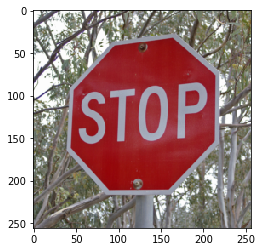

In [8]:
plot_img_from_normalized_img(transformed_img.detach().numpy())

In [9]:
import json

with open("../imagenet_class_index.json") as json_file:
    class_idx = json.load(json_file)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [10]:
idx2label[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## Model definition

In [11]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [12]:
class ImageDot(nn.Module):
    """
    Class to treat an image with translucent color dots.
    forward method creates a blended image of base and color dots.
    Center positions and colors are hard-coded.
    """
    def __init__(self):
        super(ImageDot, self).__init__()
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
        self.alpha = 0.9
        self.radius = 25.0
        self.beta = 2.0
        self.center = nn.Parameter(torch.tensor([
            [0.25, 0.25], [0.25, 0.5], [0.25, 0.75],
            [0.5, 0.25], [0.5, 0.5], [0.5, 0.75],
            [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]]),
            requires_grad=True)
        self.color = nn.Parameter(torch.tensor([
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
            requires_grad=True)

    def forward(self, x):
        _, _, height, width = x.shape
        blended = x
        for idx in range(self.center.shape[0]):
            mask = self._create_circle_mask(height, width,
                                            self.center[idx] * 255.0, self.beta)
            normalized_color = self._normalize_color(self.color[idx],
                                                     self.means, self.stds)
            blended = self._create_blended_img(blended, mask, normalized_color)
        return blended

    def _normalize_color(self, color, means, stds):
        return list(map(lambda x, m, s: (x - m) / s, color, means, stds))

    def _create_circle_mask(self, height, width, center, beta):
        hv, wv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])
        hv, wv = hv.type(torch.FloatTensor), wv.type(torch.FloatTensor)
        d = ((hv - center[0]) ** 2 + (wv - center[1]) ** 2) / self.radius ** 2
        return torch.exp(- d ** beta + 1e-10)

    def _create_blended_img(self, base, mask, color):
        alpha_tile = self.alpha * mask.expand(3, mask.shape[0], mask.shape[1])
        color_tile = torch.zeros_like(base)
        for c in range(3):
            color_tile[:, c, :, :] = color[c]
        return (1. - alpha_tile) * base + alpha_tile * color_tile


class AttackModel(nn.Module):
    """
    Class to create an adversarial example.
    forward method returns the prediction result of the perturbated image.
    """
    def __init__(self):
        super(AttackModel, self).__init__()
        self.image_dot = ImageDot()
        self.base_model = models.resnet50(pretrained=True).eval()
        self._freeze_pretrained_model()

    def _freeze_pretrained_model(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.image_dot(x)
        return self.base_model(x)

## Model training

In [13]:
torch.manual_seed(0)

In [14]:
model = AttackModel()

Check predictions before attacks.  
The image is correctly predicted as `street_sign`.

In [15]:
pred = model.base_model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-10:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

class: harvester, idx: 595, logit: 6.0803
class: boathouse, idx: 449, logit: 6.5917
class: scoreboard, idx: 781, logit: 6.7801
class: chainlink_fence, idx: 489, logit: 7.7015
class: birdhouse, idx: 448, logit: 7.9526
class: mailbox, idx: 637, logit: 7.9899
class: barn, idx: 425, logit: 7.9944
class: traffic_light, idx: 920, logit: 8.5474
class: water_tower, idx: 900, logit: 9.2191
class: street_sign, idx: 919, logit: 13.6607


Check the initial masks.

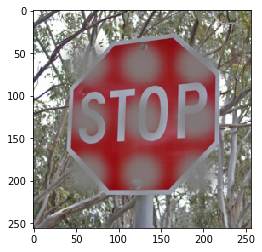

In [16]:
dotted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(dotted_img.squeeze().detach().numpy())

In [17]:
# 919: street_sign
# 595: harvester

def compute_loss(pred: torch.Tensor, true_label_idx: int, target_label_idx: int,
                 is_targeted: bool) -> torch.Tensor:
    # Targeted: - loss(true_label) + loss(target_label)
    # Non-targeted: - loss(true_label)
    assert true_label_idx is not None
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    if is_targeted:
        target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
        return torch.mean(- true_label_contrib + target_label_contrib)  # targeted
    else:
        return torch.mean(- true_label_contrib)  # non-targeted

In [18]:
lr = 0.008
loss_function = nn.NLLLoss()

for epoch in range(200):
    if (epoch + 1) % 50 == 0:
        lr *= 0.5
    model.zero_grad()
    pred = model(transformed_img.unsqueeze(0))
#     loss = compute_loss(pred, 919, -1, False)  # Non-targeted
    loss = compute_loss(pred, 919, 595, True)  # Targeted
    loss.backward(retain_graph=True)

    print(f"epoch: {epoch + 1}, loss: {loss.data:.4f}")

    for param in model.parameters():
        if param.requires_grad == True:
            param.data = torch.clamp(param.data - param.grad.data * lr, min=0.0, max=1.0)

epoch: 1, loss: 4.9227
epoch: 2, loss: 5.8029
epoch: 3, loss: 6.0072
epoch: 4, loss: 5.8904
epoch: 5, loss: 6.3028
epoch: 6, loss: 5.4142
epoch: 7, loss: 4.7694
epoch: 8, loss: 3.4155
epoch: 9, loss: 6.5845
epoch: 10, loss: 2.9668
epoch: 11, loss: 4.9375
epoch: 12, loss: 1.6439
epoch: 13, loss: 4.1701
epoch: 14, loss: 5.0988
epoch: 15, loss: 3.8792
epoch: 16, loss: 2.9104
epoch: 17, loss: 3.0354
epoch: 18, loss: 4.0703
epoch: 19, loss: 3.2874
epoch: 20, loss: 2.2319
epoch: 21, loss: 4.2326
epoch: 22, loss: 5.3505
epoch: 23, loss: 4.6257
epoch: 24, loss: 3.1736
epoch: 25, loss: 2.0664
epoch: 26, loss: 2.9431
epoch: 27, loss: 1.6256
epoch: 28, loss: 1.9194
epoch: 29, loss: 2.4247
epoch: 30, loss: 2.6296
epoch: 31, loss: 1.2542
epoch: 32, loss: 3.3464
epoch: 33, loss: 3.2341
epoch: 34, loss: 3.1143
epoch: 35, loss: 2.2564
epoch: 36, loss: 0.2512
epoch: 37, loss: 1.8199
epoch: 38, loss: 2.6567
epoch: 39, loss: 3.1826
epoch: 40, loss: 0.5519
epoch: 41, loss: 2.0467
epoch: 42, loss: 1.9599
e

In [19]:
for elem in model.parameters():
    if elem.requires_grad == True:
        print(elem)

Parameter containing:
tensor([[0.0966, 0.3986],
        [0.5581, 0.3826],
        [0.5217, 0.2392],
        [0.7886, 0.2426],
        [0.2120, 0.3207],
        [0.5240, 0.5549],
        [0.4114, 0.8288],
        [0.2018, 0.7084],
        [0.9595, 0.5994]], requires_grad=True)
Parameter containing:
tensor([[0.7394, 0.4482, 0.5206],
        [0.7996, 0.3057, 0.7769],
        [0.8881, 0.2255, 0.6809],
        [0.8957, 0.4928, 0.5214],
        [0.9320, 0.3260, 0.3838],
        [0.8588, 0.4268, 0.3779],
        [0.9890, 0.1126, 0.4009],
        [0.7230, 0.3693, 0.5647],
        [0.2351, 0.8898, 0.4113]], requires_grad=True)


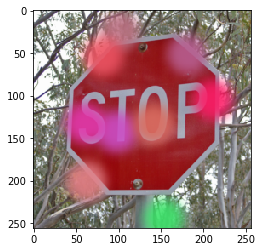

In [20]:
doted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(doted_img.squeeze().detach().numpy())

In [21]:
pred = model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-10:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

class: radio_telescope, idx: 755, logit: 7.8390
class: lumbermill, idx: 634, logit: 7.9665
class: barrow, idx: 428, logit: 8.0820
class: mailbox, idx: 637, logit: 8.2715
class: thresher, idx: 856, logit: 8.9653
class: garbage_truck, idx: 569, logit: 9.0486
class: birdhouse, idx: 448, logit: 9.3717
class: tractor, idx: 866, logit: 9.3863
class: lawn_mower, idx: 621, logit: 9.6112
class: harvester, idx: 595, logit: 14.0861


non-targeted attack expectation:

```
class: bubble, idx: 971, logit: 5.4694
class: teddy, idx: 850, logit: 5.5969
class: hair_spray, idx: 585, logit: 5.9942
class: fountain, idx: 562, logit: 6.0260
class: pinwheel, idx: 723, logit: 6.2889
class: stage, idx: 819, logit: 6.3621
class: hummingbird, idx: 94, logit: 6.9725
class: quill, idx: 749, logit: 7.5299
class: wig, idx: 903, logit: 8.2089
class: feather_boa, idx: 552, logit: 10.9632
```

targeted attack expectation:

```
class: radio_telescope, idx: 755, logit: 7.8390
class: lumbermill, idx: 634, logit: 7.9665
class: barrow, idx: 428, logit: 8.0820
class: mailbox, idx: 637, logit: 8.2715
class: thresher, idx: 856, logit: 8.9653
class: garbage_truck, idx: 569, logit: 9.0486
class: birdhouse, idx: 448, logit: 9.3717
class: tractor, idx: 866, logit: 9.3863
class: lawn_mower, idx: 621, logit: 9.6112
class: harvester, idx: 595, logit: 14.0861
```